In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, ElasticNetCV
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.feature_selection import VarianceThreshold, SelectKBest

% matplotlib inline

# Import data

In [3]:
train_df = pd.read_csv('../data/train_ENGINEERED.csv', index_col='id')
train_df.head()

,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,...,misc_feature_TenC,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
id,,,,,,,,,,,,,,,,,,,,,
109,68.0,13517,6,8,1976,2005,533.0,0.0,192.0,725.0,...,0,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,637.0,0.0,276.0,913.0,...,0,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,731.0,0.0,326.0,1057.0,...,0,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,0.0,384.0,384.0,...,0,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,0.0,676.0,676.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
test_df = pd.read_csv('../data/test_ENGINEERED.csv', index_col='id')
test_df.head()

,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,...,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
id,,,,,,,,,,,,,,,,,,,,,
2658,69.0,9142,6,8,1910,1950,0.0,0.0,1020.0,1020.0,...,0,0,0,0,0,0,0,0,0,1
2718,68.0,9662,5,4,1977,1977,0.0,0.0,1967.0,1967.0,...,0,0,0,0,0,0,0,0,0,1
2414,58.0,17104,7,5,2006,2006,554.0,0.0,100.0,654.0,...,0,0,0,0,0,0,1,0,0,0
1989,60.0,8520,5,6,1923,2006,0.0,0.0,968.0,968.0,...,0,0,0,0,0,0,0,0,0,1
625,68.0,9500,6,5,1963,1963,609.0,0.0,785.0,1394.0,...,0,0,0,0,0,0,0,0,0,1


## Because the Test and Train data didn't have all the same classes in its discrete features, there are a different number of dummy columns.
 * Fixed it by adding a col of 0s for the missing columns in test, and dropping extra cols from test

In [5]:
missing_cols = [col for col in train_df.columns if col not in test_df.columns]

for col in missing_cols:
    test_df[col] = [0]*test_df.shape[0]
test_df.drop('saleprice', 1, inplace=True)

extra_cols = [col for col in test_df.columns if col not in train_df.columns]

test_df.drop(extra_cols, 1, inplace=True)

In [6]:
test_df.shape

(879, 310)

In [7]:
train_df.shape

(2049, 311)

# Train/Test split and Fixing Skew
### we can see that the target data is skewed

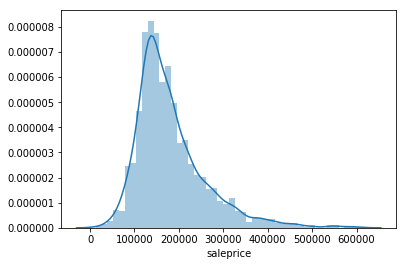

In [8]:
sns.distplot(train_df['saleprice'])

In [9]:
y_raw = train_df.saleprice
y_deskewed = np.log1p(y_raw)
X = train_df.drop('saleprice', 1)

X = X.select_dtypes(exclude='object')




### Using `np.log1p()`, we deskewed the model by targeting the log of the saleprice. 


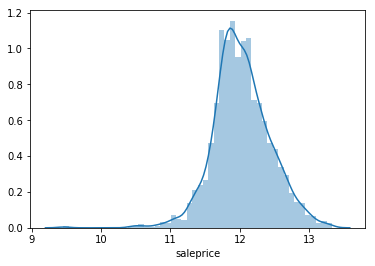

In [10]:
sns.distplot(y_deskewed)

 * notice that we now have a couple of outliers between 9 and 10. I want to remove those from the Train data

In [11]:
drop_index = y_deskewed[y_deskewed < 10].index

In [12]:
y_deskewed.drop(drop_index, inplace=True)

In [13]:
X.drop(drop_index, inplace=True)

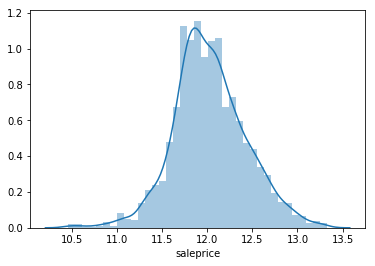

In [14]:
sns.distplot(y_deskewed)

### Finally lets run `train_test_split()`

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y_deskewed, test_size = .25, random_state=42)


# Feature selection

Get rid of columns that are similar

VarianceThreshold, SelectKBest

In [17]:
indecies = test_df.index

vt = VarianceThreshold(.05)
vt.fit(X_train)
X_train = vt.transform(X_train)
X_test = vt.transform(X_test)
test_df = vt.transform(test_df)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc =ss.transform(X_test)
test_df_sc = ss.transform(test_df)



In [18]:
X_train_sc.shape

(1535, 124)

In [19]:
skb = SelectKBest(k=20)
skb.fit(X_train_sc, y_train)

X_train_sc = skb.transform(X_train_sc)
X_test_sc = skb.transform(X_test_sc)

In [20]:
X_train_sc.shape

(1535, 20)

### Ok, ElasticNetCV

In [21]:
elas_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=500)
elas_net_cv.fit(X_train_sc, y_train)
print(elas_net_cv.l1_ratio_, elas_net_cv.alpha_)

1.0 0.00032970156869669695


In [22]:
elas_net_cv.score(X_train_sc, y_train)

0.8883974005951558

In [23]:
elas_net_cv.score(X_test_sc, y_test)

0.8653057822275355

R^2 Score: 0.8883974005951558


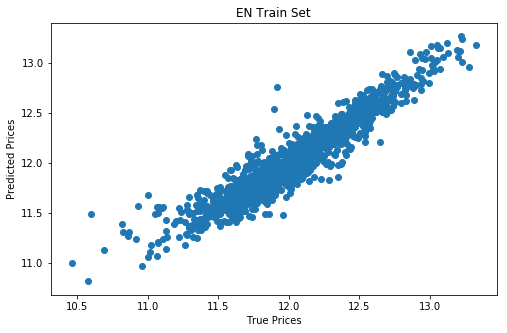

In [24]:
print(f'R^2 Score: {elas_net_cv.score(X_train_sc, y_train)}')
plt.figure(figsize=(8,5))
plt.scatter(x=y_train, y = elas_net_cv.predict(X_train_sc))
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('EN Train Set');

R^2 Score: 0.8653057822275355


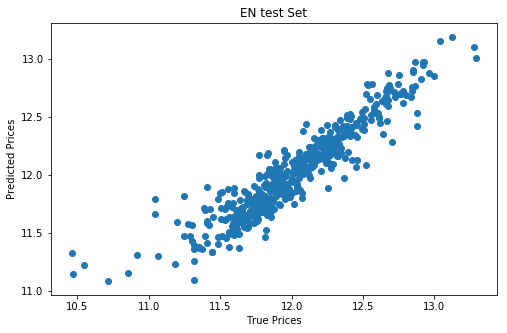

In [25]:
print(f'R^2 Score: {elas_net_cv.score(X_test_sc, y_test)}')
plt.figure(figsize=(8,5))
plt.scatter(x=y_test, y = elas_net_cv.predict(X_test_sc))
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('EN test Set');

## Trying out pipe

In [26]:
pipe = Pipeline([
    ('vt', VarianceThreshold()),
    ('ss', StandardScaler()),
    ('skb', SelectKBest()),
    ('en', ElasticNetCV())
])

params = {
    'vt__threshold' : [0, .05, .1, .2],
    'skb__k' : [5,10,15,20],
    'en__l1_ratio' : [.1, .5, .7, .9, .95, .99, 1]
}
gs = GridSearchCV(pipe, params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8849596893218374
{'en__l1_ratio': 0.1, 'skb__k': 20, 'vt__threshold': 0.2}


In [27]:
gs.score(X_train, y_train)

0.8899946062214001

In [28]:
gs.score(X_test, y_test)

0.871476510531559

R^2 Score: 0.8899946062214001


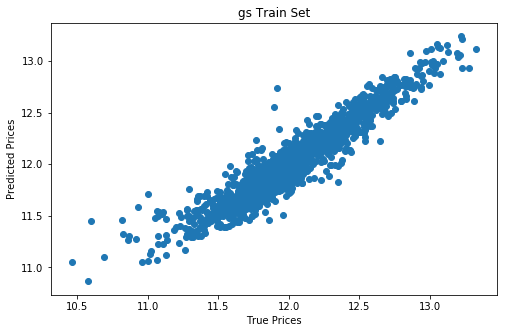

In [29]:
print(f'R^2 Score: {gs.score(X_train, y_train)}')
plt.figure(figsize=(8,5))
plt.scatter(x=y_train, y = gs.predict(X_train))
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('gs Train Set');

R^2 Score: 0.871476510531559


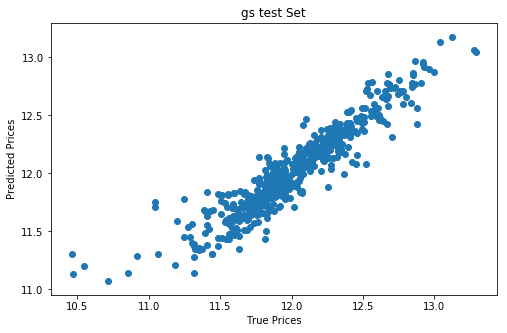

In [30]:
print(f'R^2 Score: {gs.score(X_test, y_test)}')
plt.figure(figsize=(8,5))
plt.scatter(x=y_test, y = gs.predict(X_test))
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('gs test Set');

# Predicting on test_df

In [31]:

result = gs.predict(test_df)


result = np.expm1(result)

pred_df = pd.DataFrame({'Id':indecies, 'SalePrice':result}).set_index('Id')

pred_df.head()

,SalePrice
Id,
2658,148619.598659
2718,196728.620435
2414,204560.287183
1989,128576.794858
625,172689.742334


In [32]:
pred_df.shape

(879, 1)

In [33]:
pred_df.to_csv('../data/submission.csv')